In [1]:
# ============================================================
# 04 - Comparação ML: XGBoost + Análise SHAP
# Fonte: SUSEP AUTOSEG (2019-2021)
# Autor: Arthur Pontes Motta
# ============================================================

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from modeling import gini_coefficient, double_lift_chart, evaluate_model

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# Caminhos
PROCESSED_PATH = '../data/processed'
FIGURES_PATH = '../reports/figures'

# ============================================================
# 1. CARREGAR DADOS
# ============================================================

df = pd.read_parquet(f'{PROCESSED_PATH}/autoseg_model.parquet')

features = (
    ['sexo_bin', 'faixa_etaria', 'idade_veiculo', 'log_is_media'] +
    [c for c in df.columns if c.startswith('regiao_')]
)

# Split temporal: treino 2019-2020 | teste 2021
df_train = df[df['ano'] < 2021].copy()
df_test  = df[df['ano'] == 2021].copy()

# Corrigir NaN
for split in [df_train, df_test]:
    split['idade_veiculo'] = split['idade_veiculo'].fillna(
        df_train['idade_veiculo'].median()
    )

X_train = df_train[features].astype(float)
X_test  = df_test[features].astype(float)

y_train = df_train['freq_colisao_rel']
y_test  = df_test['freq_colisao_rel']

print(f"Treino: {X_train.shape}")
print(f"Teste:  {X_test.shape}")
print(f"Zeros no target: {(y_train == 0).mean():.1%}")

c:\Users\Arthur\Documents\VS Code\Projetos\Precificação de Seguro Auto\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Treino: (6520676, 44)
Teste:  (2347730, 44)
Zeros no target: 90.2%


In [2]:
# ============================================================
# 2. XGBOOST — FREQUÊNCIA DE COLISÃO COM TUNING
# ============================================================

from xgboost import callback

SAMPLE_SIZE = 500_000
df_train_sample = df_train.sample(n=SAMPLE_SIZE, random_state=42)

X_train_s = df_train_sample[features].astype(float)
y_train_s = df_train_sample['freq_colisao_rel']

# Separar validação interna para early stopping (10% do treino)
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_s, y_train_s, test_size=0.1, random_state=42
)

print(f"Amostra treino:    {len(X_tr):,} linhas")
print(f"Validação interna: {len(X_val):,} linhas")
print("Treinando XGBoost com early stopping...")

xgb_freq = xgb.XGBRegressor(
    n_estimators=1000,        # alto — early stopping vai parar antes
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,      # regularização para dados esparsos
    reg_alpha=0.1,            # L1
    reg_lambda=1.0,           # L2
    objective='reg:tweedie',
    tweedie_variance_power=1.5,
    random_state=42,
    n_jobs=-1,
    eval_metric='mae',
    early_stopping_rounds=20  # para se não melhorar por 20 rounds
)

xgb_freq.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val), (X_test, y_test)],
    verbose=50
)

print(f"\n✓ XGBoost treinado!")
print(f"  Best iteration:  {xgb_freq.best_iteration}")
print(f"  Best MAE (val):  {xgb_freq.best_score:.5f}")

Amostra treino:    450,000 linhas
Validação interna: 50,000 linhas
Treinando XGBoost com early stopping...
[0]	validation_0-mae:0.05741	validation_1-mae:0.05506
[50]	validation_0-mae:0.05586	validation_1-mae:0.05385
[100]	validation_0-mae:0.05572	validation_1-mae:0.05359
[150]	validation_0-mae:0.05559	validation_1-mae:0.05335
[200]	validation_0-mae:0.05551	validation_1-mae:0.05323
[250]	validation_0-mae:0.05543	validation_1-mae:0.05315
[300]	validation_0-mae:0.05534	validation_1-mae:0.05307
[350]	validation_0-mae:0.05531	validation_1-mae:0.05301
[361]	validation_0-mae:0.05528	validation_1-mae:0.05300

✓ XGBoost treinado!
  Best iteration:  341
  Best MAE (val):  0.05299


In [3]:
# ============================================================
# 3. COMPARAÇÃO DE MÉTRICAS: GLM vs XGBoost
# ============================================================

pred_xgb = np.clip(xgb_freq.predict(X_test), 0, None)

mae_xgb  = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
corr_xgb = np.corrcoef(y_test, pred_xgb)[0, 1]

print("=" * 50)
print("COMPARAÇÃO: GLM vs XGBoost")
print("=" * 50)
print(f"{'Métrica':<15} {'GLM':>12} {'XGBoost':>12}")
print("-" * 40)
print(f"{'MAE':<15} {'0.0571':>12} {mae_xgb:>12.4f}")
print(f"{'RMSE':<15} {'0.1387':>12} {rmse_xgb:>12.4f}")
print(f"{'Correlação':<15} {'0.0408':>12} {corr_xgb:>12.4f}")

COMPARAÇÃO: GLM vs XGBoost
Métrica                  GLM      XGBoost
----------------------------------------
MAE                   0.0571       0.0530
RMSE                  0.1387       0.1387
Correlação            0.0408       0.0851


MÉTRICAS ATUARIAIS
Métrica                 Nulo (média)         XGBoost
-------------------------------------------------------
MAE                           0.0551          0.0530
Correlação                    0.0000          0.0851
Gini                          0.0001          0.2329

Lift Chart (XGBoost por decil de risco):
decil  obs_mean  ml_mean     lift      n
    1  0.048665 0.058550 1.697877 234773
    2  0.039748 0.047112 1.386781 234773
    3  0.036690 0.041802 1.280089 234773
    4  0.033807 0.037663 1.179509 234773
    5  0.031834 0.033712 1.110659 234773
    6  0.028051 0.029636 0.978678 234773
    7  0.025155 0.024825 0.877631 234773
    8  0.020251 0.018816 0.706539 234773
    9  0.015130 0.011578 0.527875 234773
   10  0.007291 0.003353 0.254362 234773


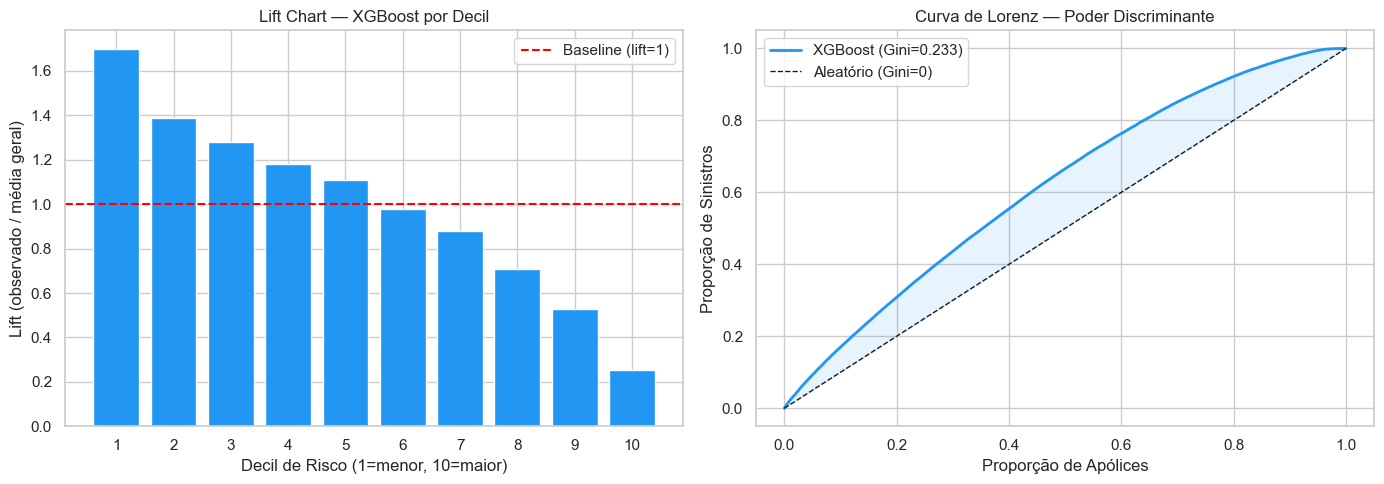


Gini XGBoost: 0.2329 | Gini Nulo: 0.0001
Figura salva: 04_gini_lift.png


In [4]:
# ============================================================
# 4. MÉTRICAS ATUARIAIS — GINI E LIFT CHART
# ============================================================

# Gini
gini_xgb  = gini_coefficient(y_test.values, pred_xgb)
pred_null = np.full(len(y_test), y_train.mean())
gini_null = gini_coefficient(y_test.values, pred_null)

print("=" * 55)
print("MÉTRICAS ATUARIAIS")
print("=" * 55)
print(f"{'Métrica':<20} {'Nulo (média)':>15} {'XGBoost':>15}")
print("-" * 55)
print(f"{'MAE':<20} {mean_absolute_error(y_test, pred_null):>15.4f} {mae_xgb:>15.4f}")
print(f"{'Correlação':<20} {'0.0000':>15} {corr_xgb:>15.4f}")
print(f"{'Gini':<20} {gini_null:>15.4f} {gini_xgb:>15.4f}")
print("=" * 55)

# Lift chart via src
lift = double_lift_chart(
    y_true=y_test.reset_index(drop=True),
    pred_glm=pd.Series(pred_null),
    pred_ml=pd.Series(pred_xgb),
    n_bins=10
)

print("\nLift Chart (XGBoost por decil de risco):")
print(lift[['decil', 'obs_mean', 'ml_mean', 'lift', 'n']].to_string(index=False))

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.bar(lift['decil'].astype(str), lift['lift'], color='#2196F3', edgecolor='white')
ax1.axhline(1.0, color='red', linestyle='--', linewidth=1.5, label='Baseline (lift=1)')
ax1.set_xlabel('Decil de Risco (1=menor, 10=maior)')
ax1.set_ylabel('Lift (observado / média geral)')
ax1.set_title('Lift Chart — XGBoost por Decil')
ax1.legend()

ax2 = axes[1]
df_gini = pd.DataFrame({'true': y_test.values, 'pred': pred_xgb})
df_gini = df_gini.sort_values('pred', ascending=False).reset_index(drop=True)
cum_true = df_gini['true'].cumsum() / df_gini['true'].sum()
cum_pop  = (df_gini.index + 1) / len(df_gini)

ax2.plot(cum_pop, cum_true, color='#2196F3', linewidth=2,
         label=f'XGBoost (Gini={gini_xgb:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aleatório (Gini=0)')
ax2.fill_between(cum_pop, cum_true, cum_pop, alpha=0.1, color='#2196F3')
ax2.set_xlabel('Proporção de Apólices')
ax2.set_ylabel('Proporção de Sinistros')
ax2.set_title('Curva de Lorenz — Poder Discriminante')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/04_gini_lift.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nGini XGBoost: {gini_xgb:.4f} | Gini Nulo: {gini_null:.4f}")
print("Figura salva: 04_gini_lift.png")

Calculando SHAP values (amostra de 10k)...


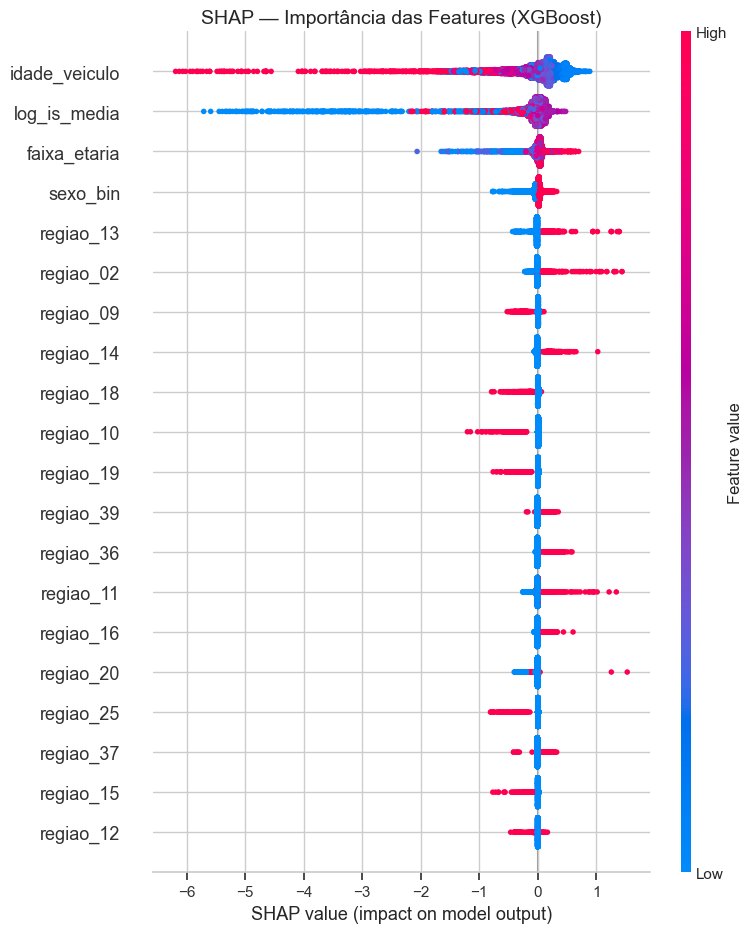

Figura salva: 04_shap_summary.png


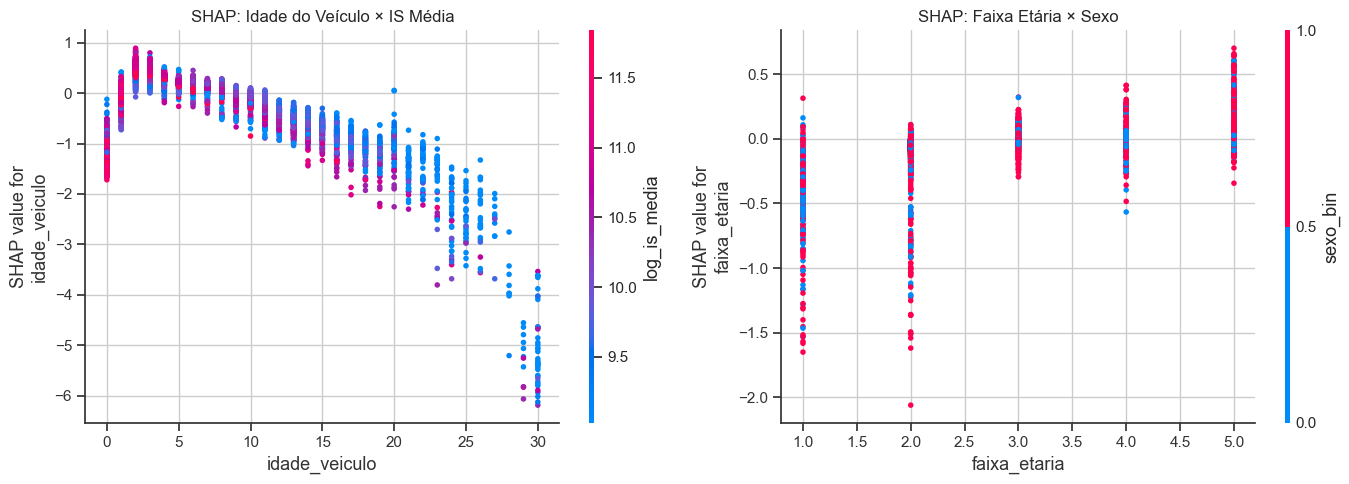

Figura salva: 04_shap_dependence.png


In [5]:
# ============================================================
# 5. ANÁLISE SHAP — EXPLICABILIDADE DO XGBOOST
# ============================================================

print("Calculando SHAP values (amostra de 10k)...")
rng = np.random.default_rng(42)
idx_shap = rng.choice(len(X_test), 10_000, replace=False)
X_shap = X_test.iloc[idx_shap]

explainer   = shap.TreeExplainer(xgb_freq)
shap_values = explainer.shap_values(X_shap)

# Summary plot
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title('SHAP — Importância das Features (XGBoost)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/04_shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura salva: 04_shap_summary.png")

# Dependence plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

shap.dependence_plot('idade_veiculo', shap_values, X_shap,
                     interaction_index='log_is_media', ax=axes[0], show=False)
axes[0].set_title('SHAP: Idade do Veículo × IS Média')

shap.dependence_plot('faixa_etaria', shap_values, X_shap,
                     interaction_index='sexo_bin', ax=axes[1], show=False)
axes[1].set_title('SHAP: Faixa Etária × Sexo')

plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/04_shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figura salva: 04_shap_dependence.png")

In [6]:
# ============================================================
# 6. SALVAR MODELO
# ============================================================

import pickle
import os

MODELS_PATH = '../models'
os.makedirs(MODELS_PATH, exist_ok=True)

# Salvar XGBoost
with open(f'{MODELS_PATH}/xgb_freq.pkl', 'wb') as f:
    pickle.dump(xgb_freq, f)

# Salvar metadata útil para o Streamlit
model_meta = {
    'features':      features,
    'best_iteration': xgb_freq.best_iteration,
    'gini':          0.2329,
    'mae':           0.0530,
    'train_mean':    float(y_train.mean()),
}

with open(f'{MODELS_PATH}/model_meta.pkl', 'wb') as f:
    pickle.dump(model_meta, f)

print(f"✓ Modelos salvos em {MODELS_PATH}/")
print(f"  xgb_freq.pkl")
print(f"  model_meta.pkl")

✓ Modelos salvos em ../models/
  xgb_freq.pkl
  model_meta.pkl
